# Time Series Forecasting with Machine Learning with Rob Mulla

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

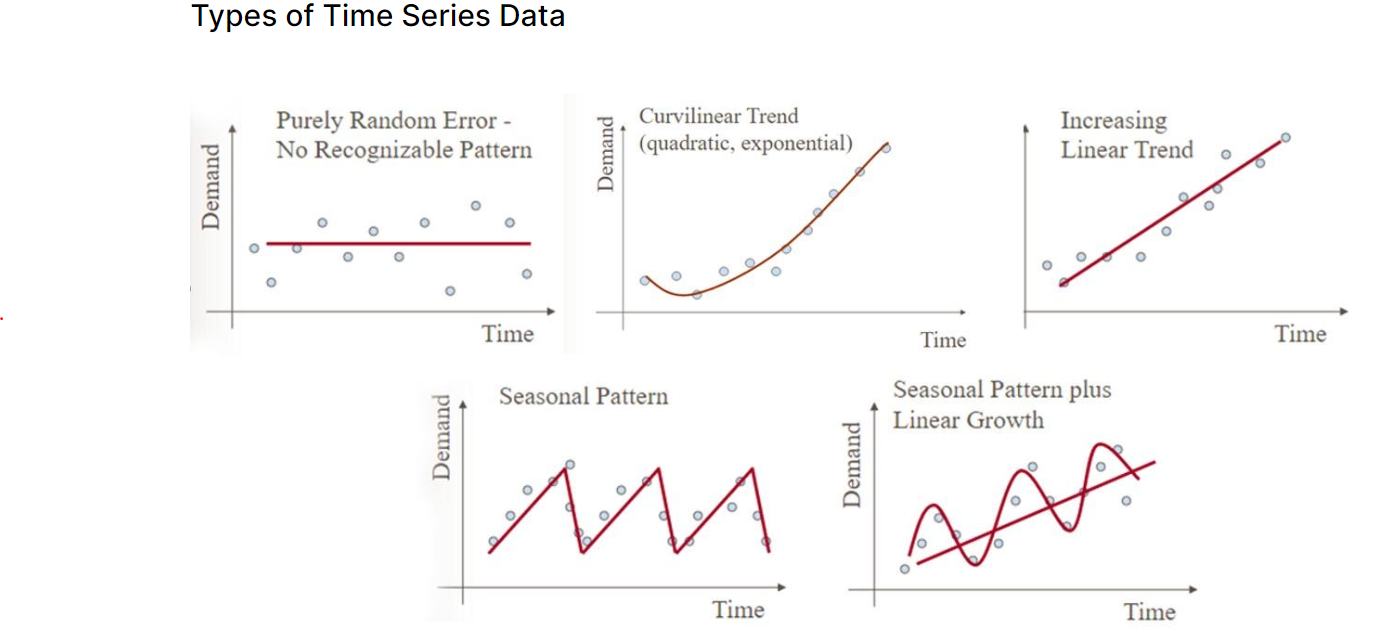

In [7]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')          ## set our index to be the datetime column

#dftype = object, we want to cast this as datatime
# shown here
df.index = pd.to_datetime(df.index)

In [5]:
color_pal= sns.color_palette()

In [6]:
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

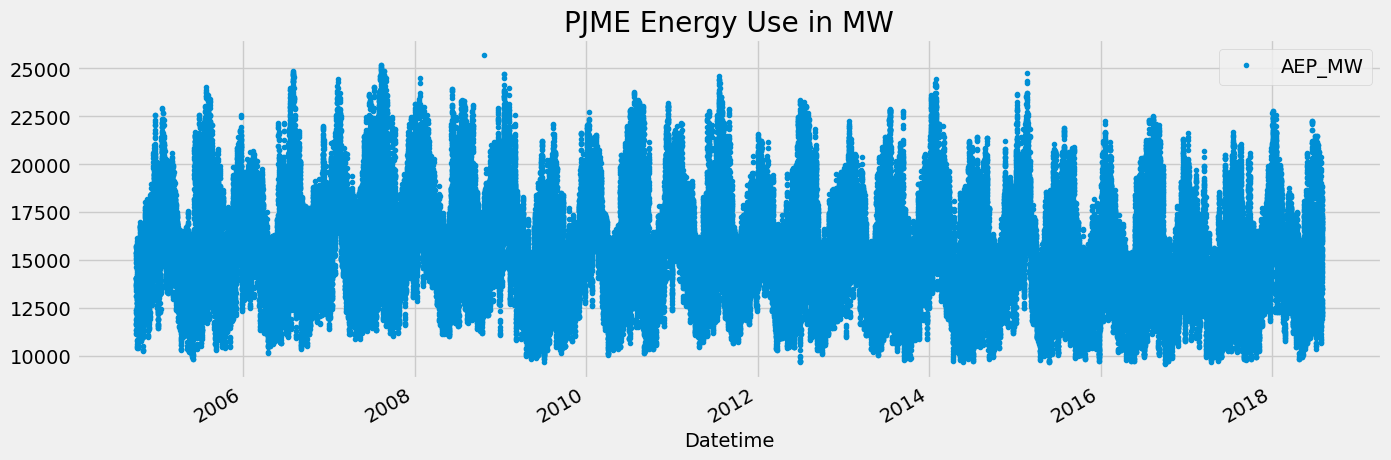

In [9]:
# plot it with style of dots instead of line
# make color first color in color palette below

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## Next is the train / test split

In [10]:
# split on the date jan 2015 and have 
#everything prior be our training data

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2004-10-01 01:00:00'), Timestamp('2004-10-01 02:00:00'),
       Timestamp('2004-10-01 03:00:00'), ...,
       Timestamp('2014-12-31 21:00:00'), Timestamp('2014-12-31 22:00:00'),
       Timestamp('2014-12-31 23:00:00')], dtype=object)

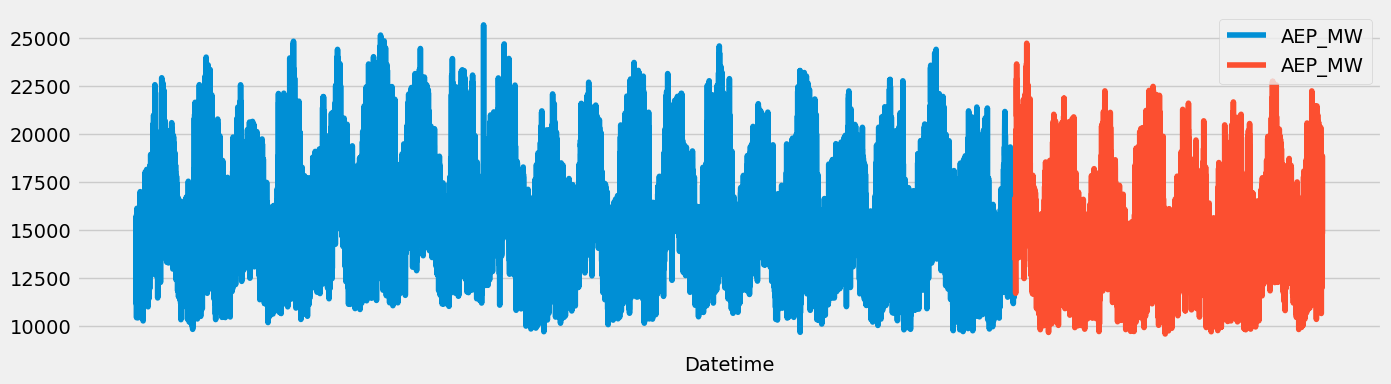

In [12]:
# take the index of less and more than target date
# locate those rows in our dataset with df.loc
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = "Training Set")
test.plot(ax=ax, label = "Test Set" )
# make a line
ax.axvline('01-01-2015', color = "black", ls='--')
plt.show()

In [14]:
# we want to one single week of data

df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]

,AEP_MW
Datetime,
2010-01-07 01:00:00,18483
2010-01-07 02:00:00,18088
2010-01-07 03:00:00,17984
2010-01-07 04:00:00,17978
2010-01-07 05:00:00,18300
...,...
2010-01-01 20:00:00,18590
2010-01-01 21:00:00,18492
2010-01-01 22:00:00,18466


<Axes: xlabel='Datetime'>

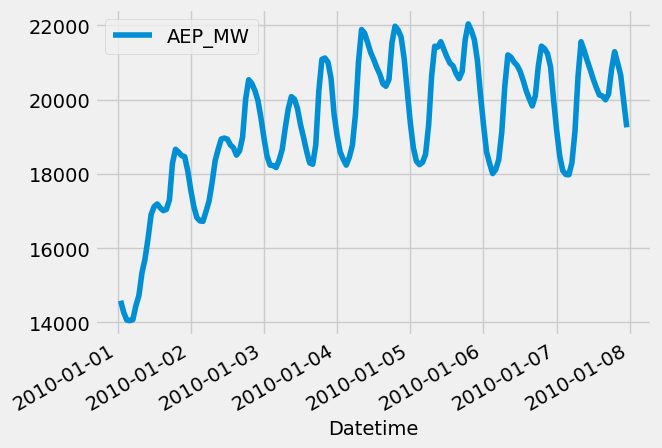

In [16]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

## Feature Creation

In [17]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

In [18]:
df.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=121273)

In [33]:
# going to add the above hour component as a new column
# going to add day of week

# put it in a function
# it will take in a dataframe and return the dataframe with features added

def create_features(df):
    # create doc string right below
    """
    Create time series features based on time series index
    """

    # this below is editing a copy of our dataframe, gets rid of some error types 
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [24]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478,1,4,4,12,2004,366
2004-12-31 02:00:00,12865,2,4,4,12,2004,366
2004-12-31 03:00:00,12577,3,4,4,12,2004,366
2004-12-31 04:00:00,12517,4,4,4,12,2004,366
2004-12-31 05:00:00,12670,5,4,4,12,2004,366


## Visualize our Feature / Target Relationship

Text(0.5, 1.0, ' MW by Hour')

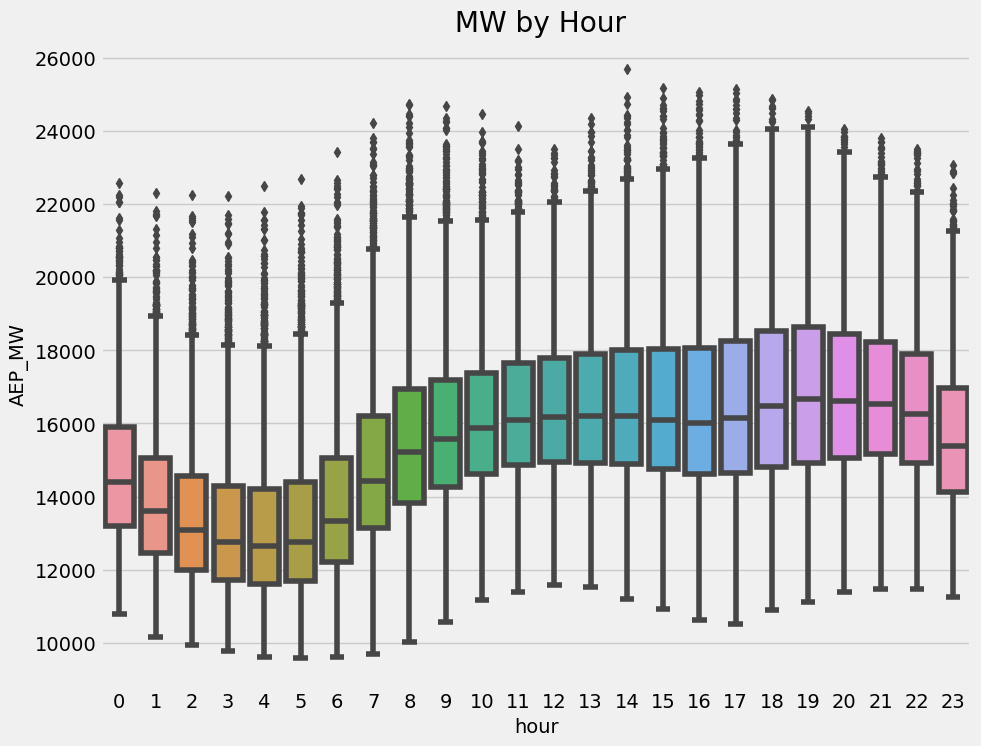

In [29]:
fig, ax = plt.subplots(figsize=(10,8))    # give it a bigger fig size
sns. boxplot(data = df, x="hour", y= "AEP_MW")
ax.set_title(" MW by Hour")


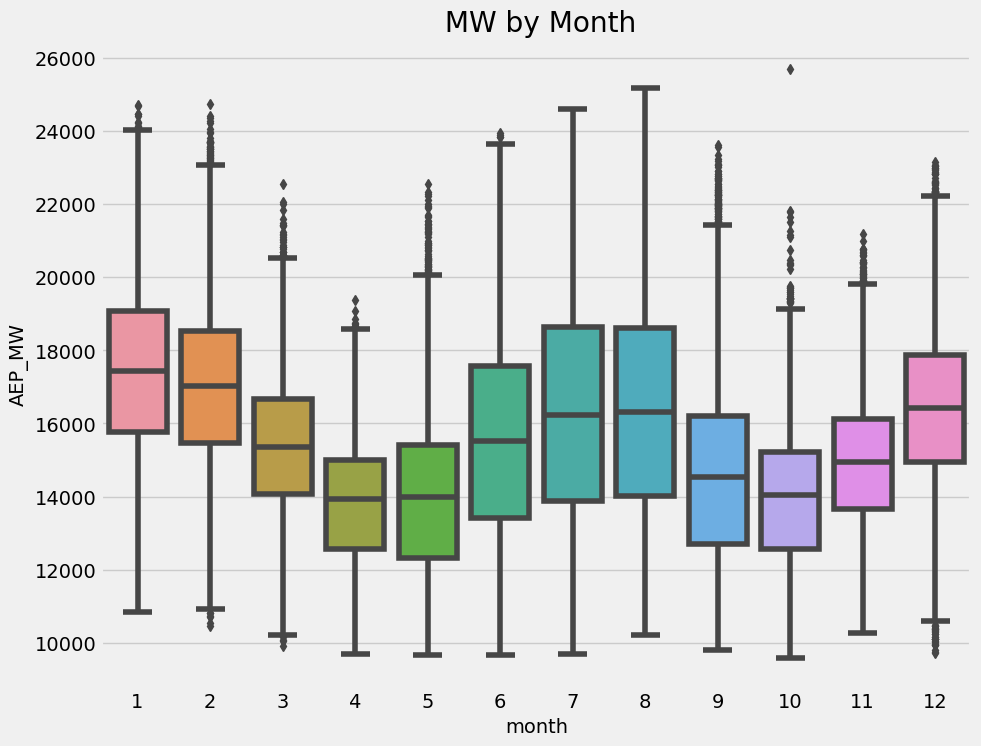

In [30]:
fig, ax = plt.subplots(figsize=(10,8))    # give it a bigger fig size
sns. boxplot(data = df, x="month", y= "AEP_MW")
ax.set_title(" MW by Month")

plt.show()

In [31]:
# The megawatt use by month peaks in winter and summer

Create our model - based on training data and test it on test data

In [34]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [40]:
# define our features

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [41]:
# make a features data set from our training data set and call it x train

X_train = train[FEATURES]
y_train = train[FEATURES]

X_test = test[FEATURES]
y_test = test[FEATURES]

In [42]:
# create regression model

#reg = xgb.XGBRegressor(n_estimator=1000)  # many things to tune, start with estimators (how many trees algorithm will create)

# then fit it on the training set
# early stop, if it doesnt improve after 50 trees
# reg.fit(X_train, y_train)
#learning rate = doesnt overfit to quick
# verbose, tell to print out validation score every 100 trees

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:816.54338	validation_1-rmse:818.75253


C:\Users\D8ISU4A\AppData\Local\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [19:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:298.90314	validation_1-rmse:301.44743
[200]	validation_0-rmse:109.41939	validation_1-rmse:111.40377
[300]	validation_0-rmse:40.05664	validation_1-rmse:41.57477
[400]	validation_0-rmse:14.66527	validation_1-rmse:15.85878
[500]	validation_0-rmse:5.37109	validation_1-rmse:6.43228
[600]	validation_0-rmse:1.97192	validation_1-rmse:2.98791
[700]	validation_0-rmse:0.73668	validation_1-rmse:1.74446
[800]	validation_0-rmse:0.30686	validation_1-rmse:1.30164
[900]	validation_0-rmse:0.18446	validation_1-rmse:1.14379
[999]	validation_0-rmse:0.16120	validation_1-rmse:1.08725


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

In [44]:
# reg dot tab then
reg.feature_importances_

# how much of the features were used with the trees

array([4.0014922e-03, 3.7792439e-04, 1.8340448e-02, 8.3134900e-04,
       3.8205477e-04, 9.7606671e-01], dtype=float32)

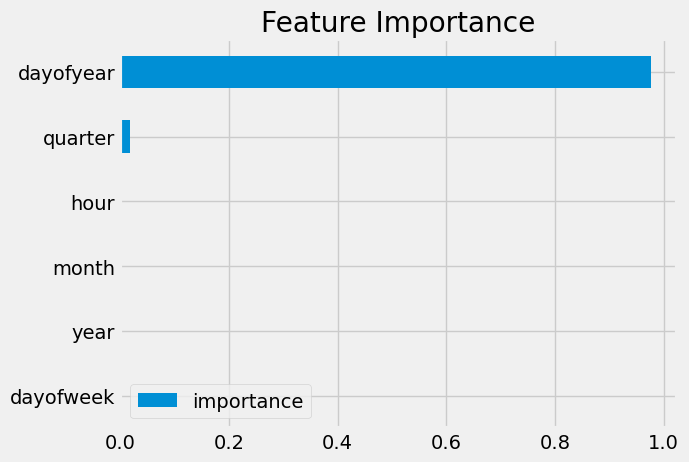

In [46]:
# hard to read above so put it in a pandas dataframe
# features importantances and names

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on the test set

In [55]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [53]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# pass in our X_test variable
# we are provided numpy of arrays for all our prodictions on our test set

ValueError: Expected a 1D array, got an array with shape (31439, 6)

KeyError: 'prediction'

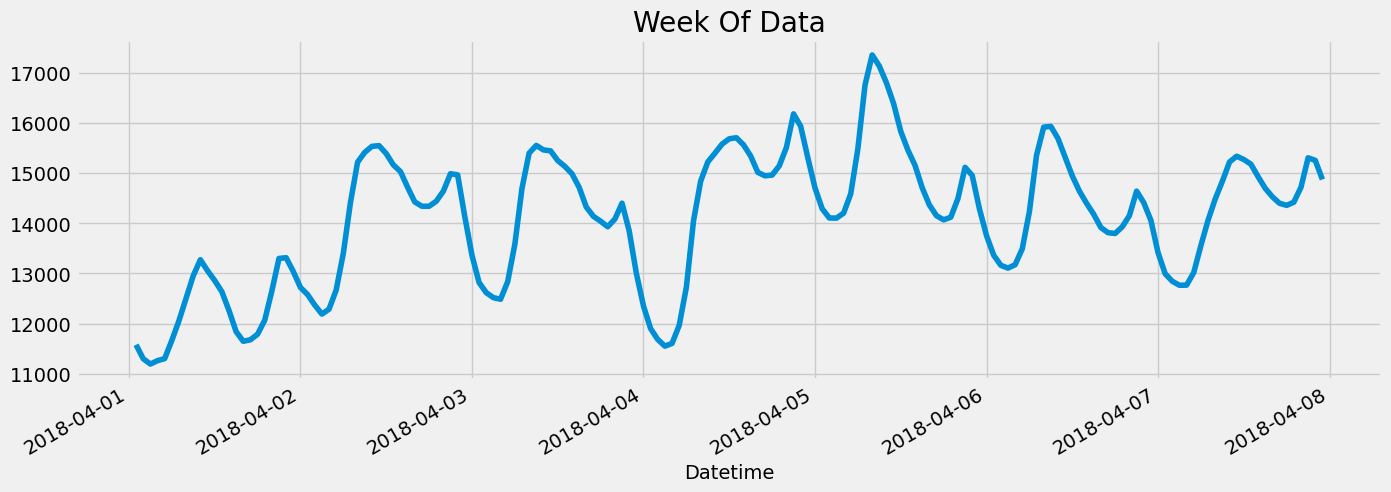

In [54]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [57]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

KeyError: 'prediction'

## Calculate Error

Look at worst and best predicted days

In [58]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

KeyError: 'prediction'